In [1]:
from utils_NXP_N7 import *  # noqa: F403,F401
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [24]:

from tensorflow.keras import layers, Sequential

def create_model_CNN(input_shape, num_classes):

    model = Sequential(name = "CNN_Model")

    # Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))

    #Bloc 1 
    model.add(layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding='same',
        activation='relu',
        input_shape=(3286,2)
    ))
    model.add(layers.BatchNormalization())

    model.add(layers.AveragePooling1D(pool_size=2))

    # Dropout 
    model.add(layers.Dropout(0.5))

    #Bloc 2
    model.add(layers.Conv1D(
        filters=8,
        kernel_size=5,
        padding='same',
        activation='relu',
    ))
    model.add(layers.BatchNormalization())

    # #Bloc 3
    # model.add(layers.Conv1D(
    #     filters=128,
    #     kernel_size=3,
    #     padding='same',
    #     activation='relu',  
    # ))
    # model.add(layers.BatchNormalization())


    # Dropout 
    model.add(layers.Dropout(0.5))

    model.add(layers.AveragePooling1D(pool_size=2))



    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='relu'))

    # Couche de sortie : LOGITS, sans softmax
    #model.add(layers.Dense(num_classes, activation=None, name="logits"))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax')) #softmax pas supporté par la carte
    


    return model
    

print("Model definition complete at 100%.")

Model definition complete at 100%.


In [25]:
#from model_definition import create_model_CNN
# Charger les données
X_train, X_test, y_train, y_test = load_data(
    "data_processed/data_processeddata_df.csv",
    "data_processed/data_processedlabels_df.csv"
)

VAL_RATIO = 0.2  # Pourcentage de données à utiliser pour la validation
percent = int(X_train.shape[0] * (1 - VAL_RATIO))
X_val, y_val = X_train[percent:], y_train[percent:]
X_train, y_train = X_train[:percent], y_train[:percent]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

# Préparer les datasets TensorFlow
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.batch(32, drop_remainder=True)

# Préparer les datasets TensorFlow
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.batch(32, drop_remainder=True)

# Définir les paramètres du modèle
input_shape = X_train.shape[1:] # Forme des données d'entrée
num_classes = 10 #len(np.unique(y_train))  # Nombre de classes pour la classification
model = create_model_CNN(input_shape, num_classes)
model.summary()

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 3286, 8)        │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3286, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_6             │ (None, 1643, 8)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1643, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 1643, 8)        │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1643, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1643, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_7             │ (None, 821, 8)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        65,690 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,248 (258.78 KB)

 Trainable params: 66,216 (258.66 KB)

 Non-trainable params: 32 (128.00 B)

In [35]:
train

<_BatchDataset element_spec=(TensorSpec(shape=(32, 3286, 2), dtype=tf.int16, name=None), TensorSpec(shape=(32, 10), dtype=tf.float64, name=None))>

In [26]:

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Définir les callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,            
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
]

In [28]:
# Entraîner le modèle
history = model.fit(
    train, validation_data=val,
    epochs=3000,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/3000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1406 - loss: 2.3786 - val_accuracy: 0.1875 - val_loss: 2.1240 - learning_rate: 0.0010
Epoch 2/3000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2009 - loss: 2.1351 - val_accuracy: 0.3125 - val_loss: 1.9981 - learning_rate: 0.0010
Epoch 3/3000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3549 - loss: 1.8774 - val_accuracy: 0.3125 - val_loss: 2.0647 - learning_rate: 0.0010
Epoch 4/3000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4062 - loss: 1.6880 - val_accuracy: 0.3646 - val_loss: 1.8739 - learning_rate: 0.0010
Epoch 5/3000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4420 - loss: 1.5574 - val_accuracy: 0.4583 - val_loss: 1.7459 - learning_rate: 0.0010
Epoch 6/3000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4888 - loss: 1.4257 - val_accuracy: 0.5000 - val_loss: 1.5477 - learning_rate: 0.0010
Epoch 7/3000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5045 - loss: 1.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8229 - loss: 0.7872 
Test Loss: 0.7871560454368591, Test Accuracy: 0.8229166865348816
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000255C5DEFEB0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Matrice de confusion :
 [[12  0  0  0  0  0  4  0  0  0]
 [ 0  9  1  0  0  1  0  0  0  0]
 [ 0  0 12  0  0  0  1  0  1  1]
 [ 0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0 13  2  0  0  0  1]
 [ 1  0  0  0  2 10  0  0  0  0]
 [ 1  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  1  0  1  0 11  0  0]
 [ 0  0  0  1  1  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 11]]

Precision : 0.8731226766808678
Recall    : 0.8591549295774648
F1-score  : 0.861320030432379


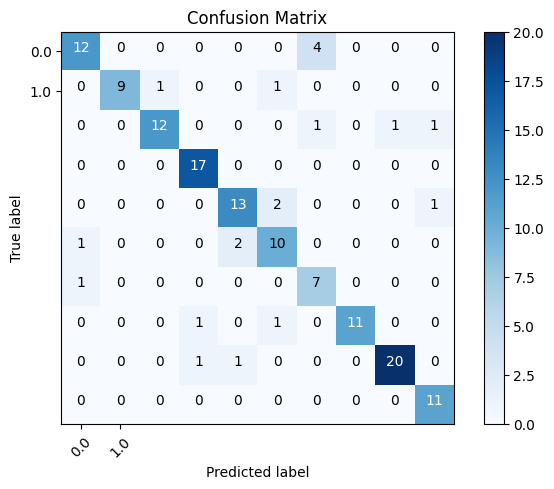

In [29]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(val)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


# # Matrice de confusion
# y_pred = np.argmax(model.predict(X_test), axis=-1)
# cm = tf.math.confusion_matrix(y_test, y_pred, num_classes = 10)

# cm = cm.numpy()

# Prédictions + matrice de confusion
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)

cm = tf.math.confusion_matrix(y_test, y_pred)
class_names = [str(c) for c in np.unique(y_train)]
cm = cm.numpy() 
print("\nMatrice de confusion :\n", cm)
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")


# Calcul des métriques : précision, rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print(f"\nPrecision : {precision}")
print(f"Recall    : {recall}")
print(f"F1-score  : {f1}")

In [30]:
# Suppresion de la derniere couche pour compatibilité NXP
model_trunc = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [31]:
# Sauvegarde du modèle complet
model.save("model_saved.keras")
print("model saved.")


# Sauvegarde du modèle tronqué
model_trunc.save("model_trunc_saved.keras")
print("model_trunc saved.")

model saved.
model_trunc saved.


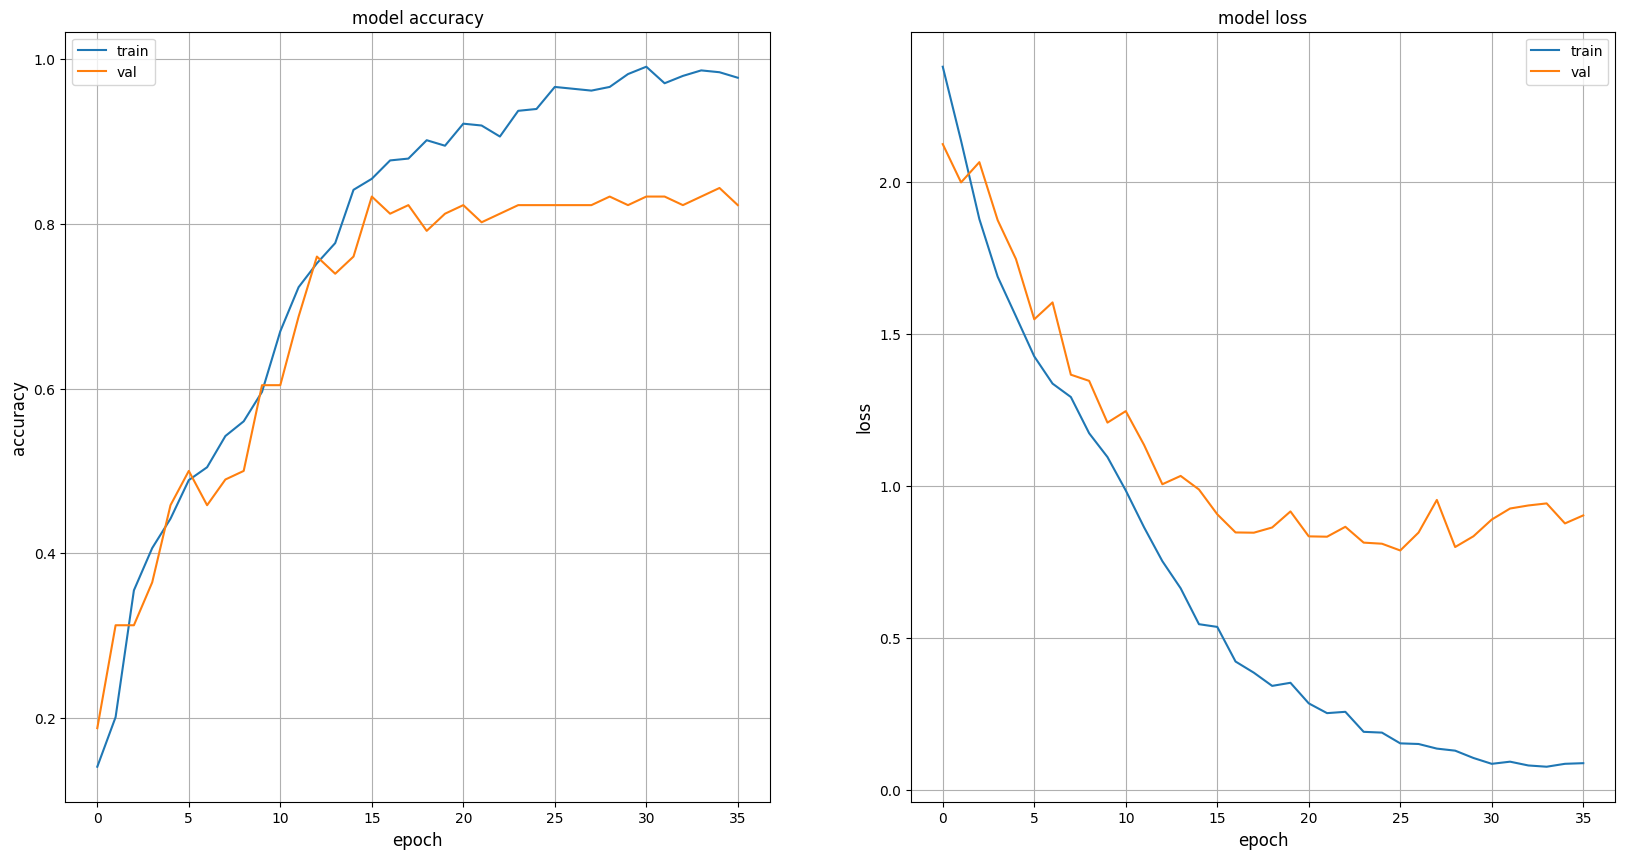

In [32]:
plot_scores(history)  # Plot validation accuracy

In [20]:
y_pred_full  = np.argmax(model.predict(X_test), axis=1)
y_pred_trunc = np.argmax(model_trunc.predict(X_test), axis=1)

# Vérifier combien de prédictions diffèrent
diff = np.mean(y_pred_full != y_pred_trunc)
print("Taux de prédictions différentes :", diff)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Taux de prédictions différentes : 0.9366197183098591


In [33]:
# Model quantization

# Representative dataset generator
def representative_data_gen():
    for i in range(50): #X_test[:50]
        yield [X_train[i:i+1].astype(np.float32)]

# Créer le convertisseur TFLite à partir du modèle Keras sauvegardé
converter = tf.lite.TFLiteConverter.from_keras_model(model_trunc)
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Configurer la quantization int8 complète
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()

# Sauvegarder le modèle quantifié
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)
print("Quantized model saved as tflite_quant_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmp7pturmsf\assets


INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmp7pturmsf\assets


Saved artifact at 'C:\Users\BILAAA~1\AppData\Local\Temp\tmp7pturmsf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3286, 2), dtype=tf.float32, name='keras_tensor_272')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2567437477920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567437470352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567437639824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567437636480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567437636304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567437639120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567435149632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567435147696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567435148400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2567435154384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [34]:
# TensorFlow Lite Interpreter Setup
tflite_interpreter = tf.lite.Interpreter(model_path="tflite_quant_model.tflite")
tflite_interpreter.allocate_tensors()

# Insepect input and output details
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

# Quantization Parameters: Zero point and scale 
zero_point_input = input_details[0]['quantization_parameters']['zero_points'][0]
scale_input = input_details[0]['quantization_parameters']['scales'][0]

# Quantizing the test data
X_test_8 = np.round(X_test.astype(np.float32) / scale_input + zero_point_input).astype(np.uint8)

# Running Inference with the Quantized model
output_array = np.zeros((X_test.shape[0], 10))
for i in range(X_test.shape[0]):
    X = np.reshape(X_test_8[i], (1, X_test_8.shape[1], X_test_8.shape[2]))
    tflite_interpreter.set_tensor(input_details[0]['index'], X)
    tflite_interpreter.invoke()
    output_array[i] = tflite_interpreter.get_tensor(output_details[0]['index'])


output_details = tflite_interpreter.get_output_details()

zero_point_output = output_details[0]['quantization_parameters']['zero_points'][0]
scale_output      = output_details[0]['quantization_parameters']['scales'][0]

# Dequantizing the Output
y_pred_tflite = (output_array - zero_point_output) * scale_output
y_pred_tflite = np.argmax(y_pred_tflite, axis=1)



c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


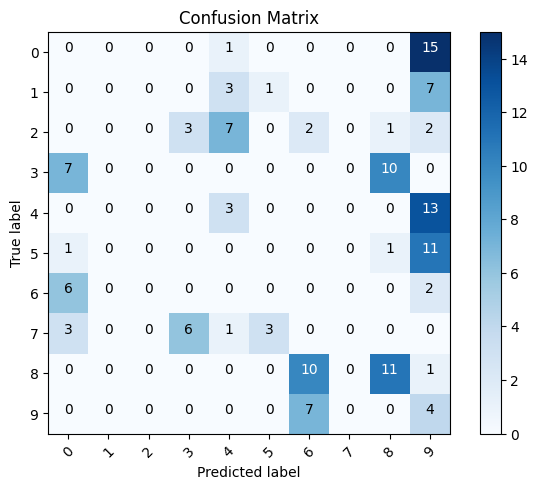

In [18]:
# Matrice de confusion pour le modèle quantifié
cm = tf.math.confusion_matrix(y_test, y_pred_tflite)
class_names = [str(c) for c in np.unique(y_train)]
cm = cm.numpy() 

plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")

In [23]:
# Sauvegarde du modèle quantifié
with open("tf_model_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)
print("Quantized model saved as tf_model_int8.tflite")

Quantized model saved as tf_model_int8.tflite


In [25]:
import tensorflow as tf
import numpy as np

def representative_data_gen():
    for i in range(100):
        data = X_train[i:i+1].astype("float32")
        yield [data]


converter = tf.lite.TFLiteConverter.from_keras_model(model_trunc)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_int8_2 = converter.convert()

output_file = "model_int8_2.tflite"
with open(output_file, "wb") as f:
    f.write(tflite_model_int8_2)

print("Saved INT8 quantized model to:",output_file)

INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmpcf2s9a07\assets


INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmpcf2s9a07\assets


Saved artifact at 'C:\Users\BILAAA~1\AppData\Local\Temp\tmpcf2s9a07'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3286, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2313636766368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313636771296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637435472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637437232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637434240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637436000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637444800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637630672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637627856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2313637634544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23136

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved INT8 quantized model to: model_int8_2.tflite
